In [1]:
import os


dam_ids = []
for item in os.listdir("../SuimonSuishituDB/fixed_out/dam_data"):
    item_path = os.path.join("../SuimonSuishituDB/fixed_out/dam_data", item)
    if os.path.isdir(item_path):
        dam_ids.append(item)

print("Dam IDs:")
print(dam_ids)

Dam IDs:
['1368010829410', '1368030375030', '608061288803010', '1368010125190', '1368060260010', '1368050651020', '1368030799020', '1368071050020', '1368080255010', '1368080364020', '601320190001010', '1368030375090', '303031283318170', '1368030446230', '602081282212010', '1368080364010', '1368060778130', '1368060475060', '1368020475240', '1368050570120', '607051287711010', '601340190001010', '1368011128090', '605081285511350', '1368050544030', '1368090235070', '601010190001010', '1368021260020', '1368070853010', '1368080700040', '601340190001020', '1368050751020', '1368050931090', '1368091050080', '1368030375180', '609061289920020', '1368010325180', '1368020475190', '607041287705010', '305071285520010', '1368010332170', '609061289920060', '1368060475100', '601330190001010', '602091282226010', '607041287705020', '602071282203001', '1368080700030', '1368040365050', '1368060444010', '1368070760060', '605091285502400', '602041282223010', '1368091270070', '1368020475050', '1368040137060', 

## 全ダムで検証

In [236]:
import pandas as pd
import datetime as dt


def get_consecutive_anomaly_periods(
    df, column, threshold_upper, threshold_lower, min_consecutive_hours=1
):
    """
    連続した異常値の期間を抽出する関数

    Parameters:
    -----------
    df : pd.DataFrame
        対象のデータフレーム
    column : str
        分析対象の列名
    threshold_upper : float
        上限閾値
    threshold_lower : float
        下限閾値
    min_consecutive_hours : int, optional
        最小連続時間数（デフォルト: 1）
        この時間以上連続した異常のみを抽出

    Returns:
    --------
    pd.DataFrame
        連続異常期間の情報（開始日時、終了日時、継続時間、初期勾配値、異常タイプ）
    """
    # 異常値のフラグを作成
    is_anomaly = (df[column] >= threshold_upper) | (df[column] <= threshold_lower)

    # 異常値の開始点を検出
    anomaly_start = is_anomaly & (~is_anomaly.shift(1, fill_value=False))

    # 結果を格納するリスト
    periods = []

    for start_date in df.index[anomaly_start]:
        idx = df.index.get_loc(start_date)

        # 連続する異常値の数をカウント
        count = 0
        for j in range(idx, len(df)):
            if is_anomaly.iloc[j]:
                if df[column].iloc[j] <= threshold_lower:
                    count += 1
                else:
                    break
            else:
                break

        # 指定した最小連続時間以上の場合のみ追加
        if count >= min_consecutive_hours:
            end_date = df.index[idx + count - 1]
            grad_value = df[column].iloc[idx]

            # 異常のタイプを判定（開始時点の値で判定）
            # if grad_value > threshold_upper:
            #     a_type = "急上昇"
            if grad_value <= threshold_lower:
                a_type = "急下降"
                periods.append(
                    {
                        "開始日時": start_date,
                        "終了日時": end_date,
                        "継続時間": count,
                        "初期勾配値": grad_value,
                        "異常タイプ": a_type,
                    }
                )
    return pd.DataFrame(periods)


def recover_capacity(df, anomaly_periods_df, column="貯水率", day_period=(2, 7)):
    for i, (_, row) in enumerate(anomaly_periods_df.iterrows()):
        start_time = row["開始日時"]
        end_time = row["終了日時"]
        cap_start = df.loc[start_time, column]
        df_target = df.loc[
            end_time
            + dt.timedelta(days=day_period[0]) : end_time
            + dt.timedelta(days=day_period[1]),
            column,
        ]
        df_target_flg = df_target > cap_start
        if df_target_flg.any():
            return True
        else:
            return False

In [ ]:
# ============================================
#! NOTE: ここを変更すること
threshold_upper = 1.0  # 上限閾値（急激な上昇）
threshold_lower = -1.0  # 下限閾値（急激な下降）

#! NOTE: 最小連続時間数を指定してください
min_consecutive_hours = 12  # 3時間以上連続した異常のみ検出

#! NOTE: 計算対象の年
st_year = 2020
ed_year = 2024

#! NOTE: ダム貯水量回復の評価時刻（日）
day_period = (2, 5)

"""
1368091270070：鶴田ダム
急激に貯水率が変動する。


"""
# ===========================================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta

from utils.daminfo import DamInfo


dam_infomation = DamInfo()

anomaly_periods_df_dict = {}
for idx, dam_id in enumerate(dam_ids):
    df_list = []
    dam_name = dam_infomation.convert_id2name(int(dam_id))
    # print(dam_name[0])
    for year_ in range(st_year, ed_year + 1):
        df = pd.read_csv(
            f"../SuimonSuishituDB/fixed_out/dam_data/{dam_id}/dam_{year_}.csv",
            encoding="utf-8",
            header=0,
            index_col=None,
        )
        df_list.append(df)
    df = pd.concat(df_list, axis=0)
    df.index = pd.to_datetime(df.date)
    df.dropna(inplace=True, how="any", axis=0)
    df.drop(columns=["date"], inplace=True)

    df["貯水率_grad"] = df["貯水率"].diff()
    anomaly_periods_df = get_consecutive_anomaly_periods(
        df, "貯水率_grad", threshold_upper, threshold_lower, min_consecutive_hours
    )

    if not anomaly_periods_df.empty:
        anomaly_periods_df["capacity_recovered"] = recover_capacity(
            df, anomaly_periods_df, day_period=day_period
        )
        anomaly_periods_df_dict[dam_id] = anomaly_periods_df

    else:
        pass
        # anomaly_periods_df_dict[dam_id] = pd.DataFrame()

/var/folders/f2/8f6ghc1n46ddyq_s9fyjqwvw0000gn/T/ipykernel_34545/279963918.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(df_list, axis=0)
/var/folders/f2/8f6ghc1n46ddyq_s9fyjqwvw0000gn/T/ipykernel_34545/279963918.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(df_list, axis=0)
/var/folders/f2/8f6ghc1n46ddyq_s9fyjqwvw0000gn/T/ipykernel_34545/279963918.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated.

In [275]:
# 事前放流失敗の事例を抽出
false_pre_release = {}
for key in anomaly_periods_df_dict.keys():
    anno = anomaly_periods_df_dict[key].loc[
        anomaly_periods_df_dict[key]["capacity_recovered"] == False
    ]
    if not anno.empty:
        false_pre_release[key] = anno
false_pre_release.keys()

dict_keys(['1368010829410', '601340190001020', '1368091270070', '1368010829060', '1368020475070', '1368050931255', '1368040260090', '1368010523040'])

In [318]:
target_idx = 5  # 上のコードで表示されたdict_keysのインデックスを指定して下さい

dam_infomation = DamInfo()
target_dam_id = list(false_pre_release.keys())[target_idx]
print(
    f"貯水率が回復しなかったダム名： {dam_infomation.convert_id2river_name(target_dam_id)[0]}水系 {dam_infomation.convert_id2name(target_dam_id)[0]}（{target_dam_id}）"
)
display(false_pre_release[list(false_pre_release.keys())[target_idx]])

貯水率が回復しなかったダム名： 木曽川水系 丸山ダム（1368050931255）


,開始日時,終了日時,継続時間,初期勾配値,異常タイプ,capacity_recovered
0,2021-07-25 04:00:00,2021-07-25 16:00:00,13,-1.4,急下降,False
1,2021-12-01 17:00:00,2021-12-02 05:00:00,13,-1.0,急下降,False
2,2022-08-13 06:00:00,2022-08-13 18:00:00,13,-1.2,急下降,False
3,2022-10-08 04:00:00,2022-10-08 20:00:00,17,-1.2,急下降,False


## 可視化用プログラム

In [250]:
anomaly_periods_df_dict.keys()  # お好きなダムをどうぞ

dict_keys(['1368010829410', '1368030375030', '608061288803010', '1368080255010', '1368080364010', '1368050570120', '605081285511350', '1368050544030', '601010190001010', '601340190001020', '1368091050080', '601330190001010', '1368040365050', '1368091270070', '1368040137060', '1368050931150', '1368010332630', '1368030376050', '1368080477030', '1368010829060', '1368020475070', '1368050570170', '1368051260060', '1368010724030', '1368010332730', '1368050931255', '1368060176040', '1368030375130', '1368030478030', '1365150315010', '1368040260090', '1368080276020', '1368010523040'])

In [315]:
from utils.daminfo import DamInfo
import datetime as dt


# !NOTE: これを編集 ------------------------
dam_id = 1368050931255

target_date = "2022-10-05"
target_date_end = "2022-10-09"
# !---------------------------------------
dam_infomation = DamInfo()
print("dam name:", dam_infomation.convert_id2name(dam_id))
print("river name:", dam_infomation.convert_id2river_name(dam_id))

df = pd.read_csv(
    f"../SuimonSuishituDB/fixed_out/dam_data/{dam_id}/dam_{target_date.split('-')[0]}.csv",
    encoding="utf-8",
    header=0,
    index_col=0,
    parse_dates=True,
)
df_tmp = df.loc[target_date:target_date_end].copy()
tmp_anomaly_periods_df = anomaly_periods_df_dict[str(dam_id)]
anomaly_periods_df = tmp_anomaly_periods_df.loc[
    tmp_anomaly_periods_df["開始日時"] >= dt.datetime.strptime(target_date, "%Y-%m-%d")
]

dam name: ['丸山ダム']
river name: ['木曽川']


In [316]:
anomaly_periods_df

,開始日時,終了日時,継続時間,初期勾配値,異常タイプ,capacity_recovered
3,2022-10-08 04:00:00,2022-10-08 20:00:00,17,-1.2,急下降,False


異常検知結果:
  急上昇異常: 25件
  急下降異常: 30件
  総異常件数: 55件
  異常率: 45.83%


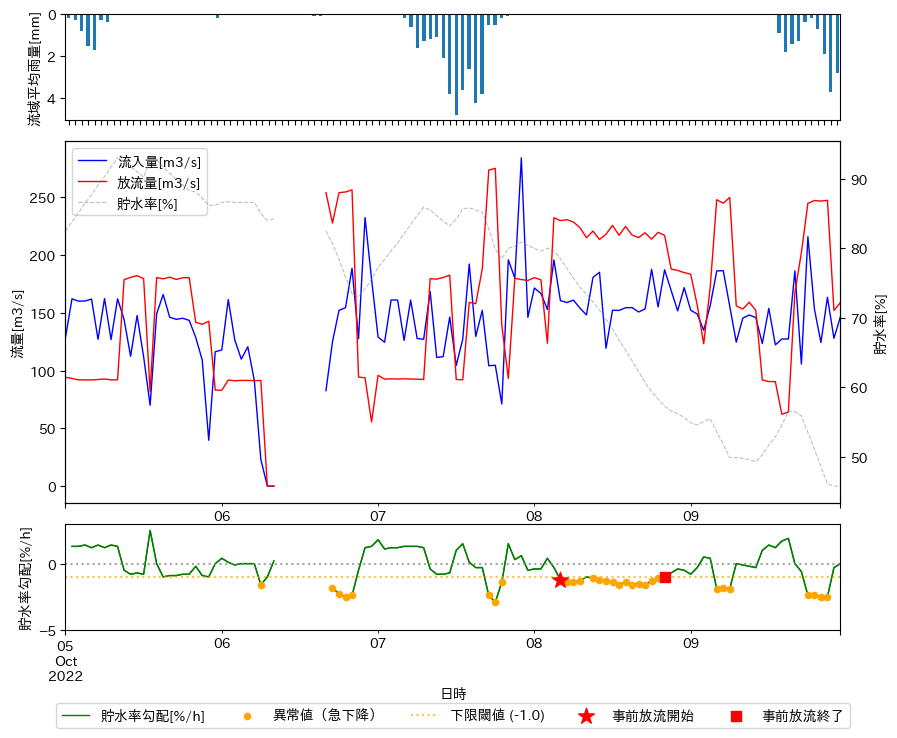

In [317]:
plt.figure(figsize=(10, 8))


ax1 = plt.subplot(5, 1, 1)
df_tmp["流域平均雨量"].plot(kind="bar", ax=ax1)
ax1.invert_yaxis()
ax1.set_xticklabels([])
ax1.set_xlabel("")

ax2 = plt.subplot(5, 1, (2, 4))
ax2_right = ax2.twinx()
df_tmp["貯水率"].plot(
    ax=ax2_right, label="貯水率[%]", color="gray", linestyle="--", linewidth=0.8, alpha=0.5
)
df_tmp["流入量"].plot(ax=ax2, label="流入量[m3/s]", color="blue", linewidth=1, alpha=1)
df_tmp["放流量"].plot(ax=ax2, label="放流量[m3/s]", color="red", linewidth=1, alpha=1)
ax2.set_xticklabels([])
ax2.set_xlabel("")
ax2_right.set_xticklabels([])
ax2_right.set_xlabel("")

ax3 = plt.subplot(5, 1, 5)
# 貯水率の勾配を計算
df_tmp["貯水率_grad"] = df_tmp["貯水率"].diff()
df_tmp["貯水率_grad"].plot(ax=ax3, label="貯水率勾配[%/h]", color="green", linewidth=1)
ax3.set_ylabel("貯水率勾配[%/h]")
ax3.set_xlabel("日時")
ax3.set_ylim(-2, 2)
ax3.legend()
# 貯水率の異常検知


# 正常範囲をプロット
df_tmp["貯水率_grad"].plot(ax=ax3, color="green", linewidth=1, label="")

# # 異常値を検出してハイライト
anomaly_upper = df_tmp["貯水率_grad"] > threshold_upper
anomaly_lower = df_tmp["貯水率_grad"] < threshold_lower

# if anomaly_upper.any():
#     ax3.scatter(
#         df_tmp.index[anomaly_upper],
#         df_tmp["貯水率_grad"][anomaly_upper],
#         color="blue",
#         s=20,
#         label="異常値（急上昇）",
#         zorder=5,
#     )

if anomaly_lower.any():
    ax3.scatter(
        df_tmp.index[anomaly_lower],
        df_tmp["貯水率_grad"][anomaly_lower],
        color="orange",
        s=20,
        label="異常値（急下降）",
        zorder=5,
    )

# 閾値ラインを表示
# ax3.axhline(
#     y=threshold_upper,
#     color="lightblue",
#     linestyle=":",
#     alpha=0.7,
#     label=f"上限閾値 ({threshold_upper})",
# )
ax3.axhline(
    y=threshold_lower,
    color="orange",
    linestyle=":",
    alpha=0.7,
    label=f"下限閾値 ({threshold_lower})",
)
ax3.axhline(
    y=0,
    color="gray",
    linestyle=":",
    alpha=0.7,
)


# 異常期間の開始点をプロット
for i, (_, row) in enumerate(anomaly_periods_df.iterrows()):
    start_time = row["開始日時"]
    end_time = row["終了日時"]
    try:
        start_grad_value = df_tmp.loc[start_time, "貯水率_grad"]
        end_grad_value = df_tmp.loc[end_time, "貯水率_grad"]
    except:
        continue
    ax3.scatter(
        start_time,
        start_grad_value,
        marker="*",
        color="red",
        s=140,
        label="事前放流開始" if i == 0 else "",
        zorder=6,
    )
    ax3.scatter(
        end_time,
        end_grad_value,
        marker="s",
        color="red",
        s=60,
        label="事前放流終了" if i == 0 else "",
        zorder=6,
    )

ax3.set_ylabel("貯水率勾配[%/h]")
ax3.set_xlabel("日時")
ax3.set_ylim(-5.0, 3.0)
ax3.legend(ncols=5, bbox_to_anchor=(0.5, -0.62), loc="upper center")


# 異常検知結果の統計情報を表示
total_anomalies = anomaly_upper.sum() + anomaly_lower.sum()
print(f"異常検知結果:")
print(f"  急上昇異常: {anomaly_upper.sum()}件")
print(f"  急下降異常: {anomaly_lower.sum()}件")
print(f"  総異常件数: {total_anomalies}件")
print(f"  異常率: {total_anomalies/len(df_tmp)*100:.2f}%")

# 両軸の凡例を統合
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_right.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2)

ax1.set_ylabel("流域平均雨量[mm]")
ax2.set_ylabel("流量[m3/s]")
ax2_right.set_ylabel("貯水率[%]")

plt.show()